# DermID: Automated Detection of Skin Lesions

This notebook uses the Bag of Visualized Words Method to Classify Benign vs Malignant Skin Lesions 

Developed by: Shawn Stapleton
Developed on: November 5, 2016

This code is free to use, but please credit the source.

# Scale Invariant Feature Transform 

In [180]:
# import the necessary packages
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.externals import joblib
from sklearn.model_selection import learning_curve, StratifiedShuffleSplit
from scipy.cluster.vq import *
from scipy import interp

from ipywidgets import FloatProgress
from IPython.display import display

import os
import random

%matplotlib inline

# Set plot style
mpl.style.use('ggplot')

### RootSIFT FUNCTION
<b>Inputs:</b>
<br>
    sift  - a OpenCV sift object used to calculate keypoints and 
            descriptiors. Default: None
<br>
    Img - a 2D or 3D (i.e. RGB) array of tuples to perform run through the RootSIFT algorithm. Default = []
<br>

<b>Outputs:</b>
<br>
    kps   - Keypoints
<br>
    desc  - SIFT Descriptors
<br>

<b>About Root Sift:</b>

Credit the the RootSIFT python implementation goes to Adrian at pyimagesearch. An excellent resource for learning about computer vision using Python.http://www.pyimagesearch.com/2015/04/13/implementing-rootsift-in-python-and-opencv/

  
Information about the openCV SIFT class can be found here:
http://docs.opencv.org/2.4/modules/nonfree/doc/feature_detection.html#sift


In [181]:
def RootSIFT(sift = None, Img = []):
    
    # if SIFT object doesn't exist, create it
    if( sift is None ):
        # default contrustor parameters
        # nfeatures=0, nOctaveLayers=3, contrastThreshold=0.04, edgeThreshold=10, sigma=1.6
        cv2.xfeatures2d.SIFT_create()
        #sift = cv2.SIFT()
 
    # Create Storage for kps and descs
    kps = []
    descs = np.array([]).reshape(0, 128)
    
     # Get the features for the first image channel, and loop through the rest, appending the features
    if Img.ndim == 3:
        for i in range(0, Img.ndim, 1):
            # compute SIFT descriptors
            (tkps, tdescs) = sift.detectAndCompute(Img[:, :, i], None)

            if (len(tkps) == 0):
                continue
            kps += tkps
            descs = np.vstack((descs, tdescs))

        del tkps, tdescs
    else:
        # compute SIFT descriptors
        (kps, descs) = sift.detectAndCompute(Img[:, :, i], None)

    # if there are no keypoints or descriptors, return an empty tuple
    if len(kps) == 0:
        return ([], None)

    # apply the Hellinger kernel by first L1-normalizing and taking the
    # square-root. eps is used to avoid divide by zeros
    eps=1e-7
    descs /= (descs.sum(axis=1, keepdims=True) + eps)
    descs = np.sqrt(descs)

    # return a tuple of the keypoints and descriptors
    return (kps, descs)

### DenseSIFT FUNCTION
<b>Inputs:</b>
    Img - a 2D array of tuples to perform run through the SIFT
            algorithm. Default = []
    PatchLevels - a list of patch levels (think window size) to perform 
    RootSIFT analysis within. Default = [128, 58, 26, 12]
    GridSteps - The grid step size. Default = 8
            
<b>Outputs:</b>
    kps   - Keypoints
    desc  - SIFT Descriptors


<b>About Dense Sift:</b>
DenseSIFT divides into regions set by a given PatchLevel and GridStep, performing RootSIFT. Additionally, multiple PatchLevels can be used and the function will iterate through them. This function is slow and would benefit from parallelization.

In [182]:
def denseSIFT(Img=None, PatchLevels=[128, 58, 26, 12], GridStep=8):
    if (Img is None):
        return

    # Clear the feature space
    # SIFT_Features = []
    kps = []
    descs = np.array([]).reshape(0, 128)
       
    # Create a new openCV sift object
    cv2.xfeatures2d.SIFT_create()
    #sift = cv2.SIFT()
        
    # Iterate through the patch levels and perform RootSIFT in each Patch
    for WinSize in PatchLevels:
        print('\t Patch Level: %d' % WinSize)
        for (x, y, pImg) in self.sliding_window(Img, StepSize=GridStep, WndSize=(WinSize, WinSize)):

            # if the window is outside of image boundaries, then don't use it for analysis
            if pImg.shape[0] != WinSize or pImg.shape[1] != WinSize:
                continue
            
            # Perform RootSIFT
            (tkps, tdescs) = RootSIFT(sift, pImg[:, :, i])
            if (len(tkps) == 0): 
                continue

            kps += tkps
            descs = np.vstack((descs, tdescs))
            del tkps, tdescs

    return (kps, descs)

# A helper function to perform sliding window across the image
def sliding_window(self, Img, StepSize, WndSize):
    # slide a window across the image
    for y in xrange(0, Img.shape[0], StepSize):
        for x in xrange(0, Img.shape[1], StepSize):
            # yield the current window
            yield (x, y, Img[y:y + WndSize[1], x:x + WndSize[0], :])

# Function to load the skin lesion images

In [183]:
# Fetch Image Data
def FetchImageData(ImgDBPath = "", N = None, ):

    if( len(ImgDBPath) == 0 ):
        print("Error loading images, can't find image path")
        return []

    # Get Malignant image file paths
    f = os.listdir(ImgDBPath)
    if( N is None ):
        N = len(f)
        
    # Randomly select order of images to load since they the file system sorts them by name
    f = random.sample(f, N)
    
    # Create a dictionary to store the skin lesion image data (SLI)
    # images - RGB image data
    # targets - image classification (0, 1)
    # target_names - image label (benign, malignant)
    # image_names - filename of image
    sli_data = {'DESCR': 'ISIC archived melanoma and benign images', 
                'images': [], 
                'targets': [], 
                'target_names': [], 
                'image_names': []}
    
    # A progress bar
    pbar = FloatProgress(min=0, max=N)
    display(pbar)

    # Loop through files, load image, and store in dictionary
    for i in range(N):
        if f[i].startswith("."):
            continue
        
        # Load the image
        Img = Image.open(ImgDBPath + f[i])  
        sli_data['images'].append(np.array(Img,np.uint8))          
        sli_data['image_names'].append(f[i])
        if('malignant' in f[i] ):
            sli_data['targets'].append(1)
        else:        
            sli_data['targets'].append(0)
            
        sli_data['target_names'].append(f[i].split('_')[0])
        
        # print("%d of %d\nFile: %s\n\tTarget Name: %s\n\tTarget: %d\n\t"%(i,N,f[i], f[i].split('_')[0], 'malignant' in f[i]))
        # Update the progress bar
        pbar.value += 1
        pbar.description = f[i]
    
    return sli_data



# Analyze Images using RootSIFT

In [185]:
# Load all the imaging data
print("Loading Image Data")
N= 1300 # Define Number of images to load
ImageDBPath = '/Users/staples/Library/Mobile Documents/com~apple~CloudDocs/Insight Data Science/BossaNova Kaggle/ImageDB/'
ImgData = FetchImageData(ImageDBPath, N)
print("Image Data Loaded")

Loading Image Data


Image Data Loaded


In [188]:
# A progress bar
f = FloatProgress(min=1, max=len(ImgData['images']))
f.value = 1
display(f)

# Storage for the RootSIFT Descriptors
SIFT_Descriptors = []
KP_Descriptors = []

# Perform RooSIFT on loaded Images
#sift = cv2.SIFT()
sift = cv2.xfeatures2d.SIFT_create()

idx = []
for i, Img in enumerate(ImgData['images']):
    features = RootSIFT(sift, Img)
    
    # Store Index of Images that have no descriptors, we will remove that data later
    if (len(features[0]) == 0):
        idx.append(i)
        continue

    # Only save descriptors
    KP_Descriptors.append(features[0])
    SIFT_Descriptors.append(features[1])
    
    # Update the progress bar
    f.value += 1
    f.description = "SIFT'ing Image: %d of %d"%(i,len(ImgData['images']))
    
print "Done Extraction SIFT Descriptors"

Done Extraction SIFT Descriptors


Example of RootSIFT Applied to a Skin Lesion Image

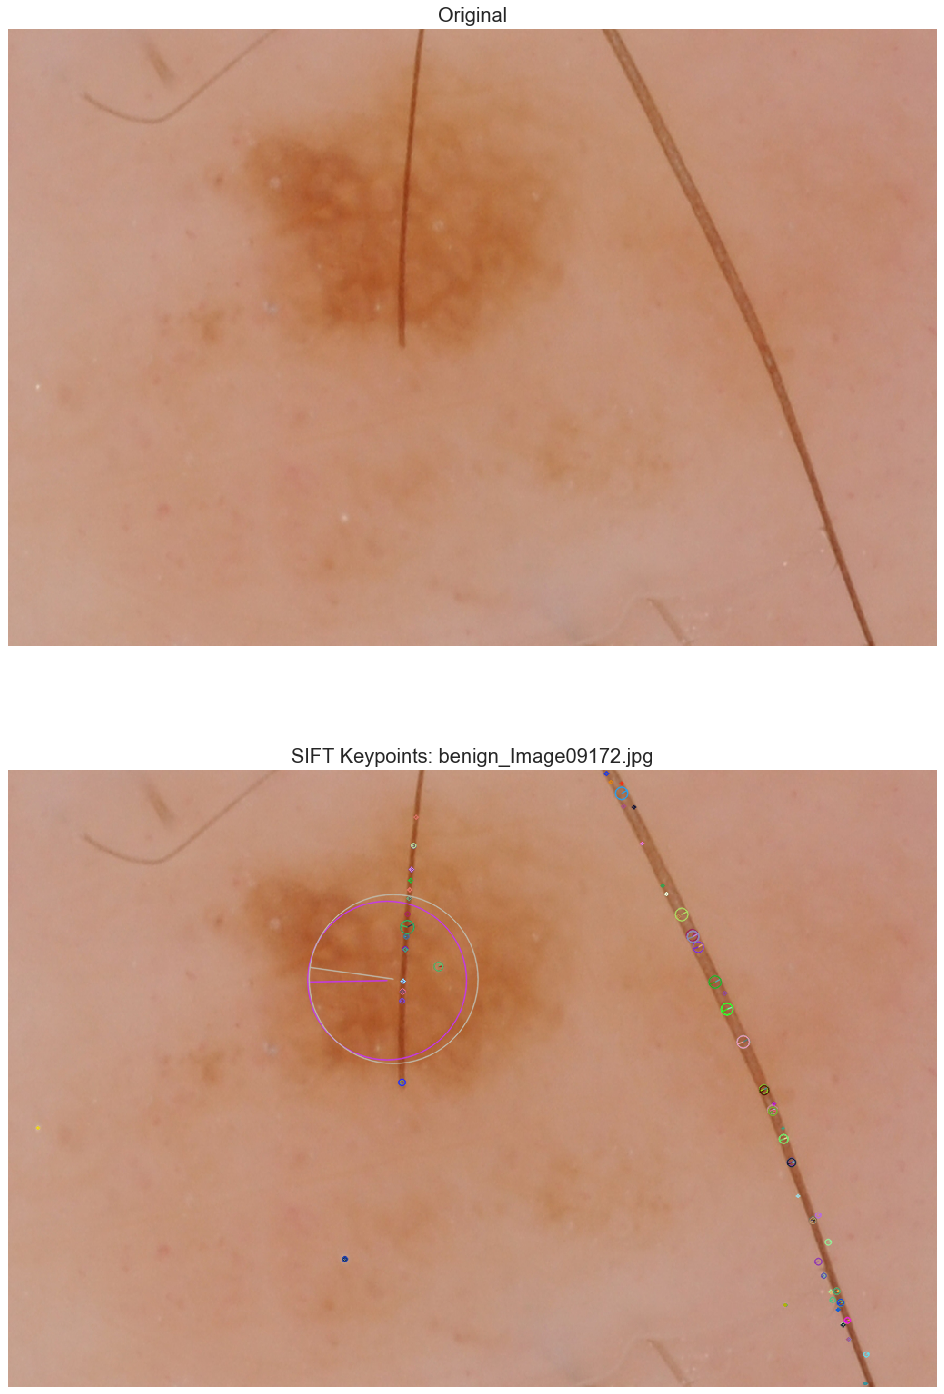

In [189]:
# Show an example image with keypoints
f, axarr = plt.subplots(2,1, sharex=False,figsize = (25,25))

ImgInd = 14
img=cv2.drawKeypoints(ImgData['images'][ImgInd],KP_Descriptors[ImgInd],outImage=None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

axarr[0].imshow(ImgData['images'][ImgInd],aspect="equal")
axarr[0].set_xticks([])
axarr[0].set_yticks([])
axarr[0].set_title("Original", FontSize=20)
axarr[1].imshow(img,aspect="equal")
axarr[1].set_xticks([])
axarr[1].set_yticks([])
axarr[1].set_title("SIFT Keypoints: " + ImgData['image_names'][ImgInd], FontSize=20)

Remove data where SIFT failed, from further analysis

In [190]:
# SIFT fails to extract keypoints and descriptors on some images. Here we show them
if( len(idx) > 0 ) :
    print "RootSIFT failed on %d images"%len(idx)

    #N = divmod(np.sqrt(len(idx)))
    #N,R = divmod(np.sqrt(len(idx)),1)
    #R = np.int16(np.ceil(R))
    #N = np.int16(N)
    
    #print(N,R)
    # Display the image that could not be SIFT'ed
    # Typically they are blurry images and helps define image quality requirements
    #f, axarr = plt.subplots(nrows=N,ncols=N+R, sharex=False,figsize = (20,10))
 
    #for i,j in enumerate(idx):
    #    axarr[i].imshow(ImgData['images'][j],aspect="equal")
    #    axarr[i][j].set_title(ImgData['image_names'][j])
    #    axarr[i][j].set_xticks([])
    #    axarr[i][j].set_yticks([])

    # Remove any images were the RootSIFT failed to identify any descriptors
    print('Removing Images' )
    ImgData['images'] = np.delete(ImgData['images'], idx, 0)
    ImgData['image_names']= np.delete(ImgData['image_names'], idx, 0)
    ImgData['targets']= np.delete(ImgData['targets'], idx, 0)
    ImgData['target_names']= np.delete(ImgData['target_names'], idx, 0)
    
            


RootSIFT failed on 29 images
Removing Images


# Cross-Validation and Normalization
Initialize stratified shuffled Cross-Validation (CV) and Normalize the SIFT Descriptors

In [191]:
x_data = SIFT_Descriptors
y_data = ImgData['targets']
y_names = ImgData['target_names']

CV = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=25)

# Normalize the descriptors
x_mean = np.vstack(x_data).mean()
x_std = np.vstack(x_data).std()
x_data -= x_mean
x_data /= x_std

print("Normalized Description:\nMean: %0.2f\nStd: %0.2f\nMin: %0.2f\nMax: %0.2f"%(np.vstack(x_data).mean(),np.vstack(x_data).std(),np.vstack(x_data).min(),np.vstack(x_data).max()))

Normalized Description:
Mean: 0.00
Std: 1.00
Min: -1.16
Max: 5.35


# Dimensionality Reduction
Here we use Principal Component Analysis (PCA) to remove features. Here we choose to retain 90% of the variance in the features

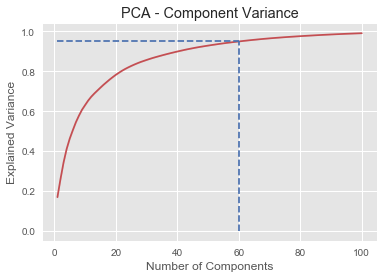

In [192]:
n_components =100

ExplVar = np.zeros((CV.get_n_splits(x_data, y_data), n_components), np.float)

for i, ind in enumerate(CV.split(x_data,y_data)):
    
    X_train = np.vstack(x_data[ind[0]])
    clfPCA = PCA(n_components=n_components, svd_solver='randomized', whiten=True, iterated_power=5)

    # Fit PCA
    clfPCA.fit(X_train)
    ExplVar[i][:] = np.cumsum(clfPCA.explained_variance_ratio_) 

# Plot a figure looking at the cummulative sum of the explained variance
plt.figure()
plt.title("PCA - Component Variance")
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance")
plt.fill_between(range(1,n_components+1,1), ExplVar.mean(axis=0) - ExplVar.std(axis=0),
                     ExplVar.mean(axis=0) + ExplVar.std(axis=0), alpha=0.1, color="r")
plt.plot(range(1,n_components+1,1), ExplVar.mean(axis=0), '-', color="r")
plt.plot([1,60], [0.95,0.95], '--', color="b")
plt.plot([60,60], [0,0.95], '--', color="b")



# Train the Codebook and SVM Classifier


In [193]:
def GetCode(words, distance, NumWords, NumBins=4, lmin=0.6, lmax=1.6):

    # Initialize storage for image code 
    Code = np.zeros((NumWords,NumBins),np.float64) 

    # Look through descriptors and create local code
    for i in range(NumWords):
        idx = np.where(i == words)[0]

        if(len(idx) == 0):
            Code[i] = np.zeros(NumBins)
            continue

        amin = lmin*(distance[idx].mean()+distance[idx].std())
        amax = lmax*(distance[idx].mean()+distance[idx].std())

        # Get Normalized Histogram which defines the Code for this Word
        hist = np.histogram(distance[idx],NumBins,(amin,amax),True)[0]

        # Save Code
        # Code[i] = np.append(hist,len(idx))
        Code[i] = hist

    return Code.flatten()

In [194]:
param_grid = {'C': [0.01, 0.1, 1, 5, 10, 25, 50, 75, 100, 1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }

subsampling = 1 # Subsampling can be used to speed up the cultering
n_components = 60  
NumWords = 100  # Number of words to include in our vocabulary
NumBins = 4

svm_clf = GridSearchCV(svm.SVC(kernel='rbf', class_weight='balanced'), param_grid)

# Reduce dimensionality to 60 components when training the PCA, as they explain 95% of the variance

clfPCA = PCA(n_components=n_components, svd_solver='randomized', whiten=True, iterated_power=5)


# Init variables for ROC, ROC_AUC, Recall, Precision, F1_Score, Confusion Matrix
N = CV.get_n_splits(x_data, y_data)
tpr = np.zeros((N,100),np.float64) 
fpr = np.linspace(0,1,100)
roc_auc = np.zeros((N,1),np.float64) 
Recall = np.zeros((N,1),np.float64) 
Precision = np.zeros((N,1),np.float64) 
F_Score = np.zeros((N,1),np.float64) 
cm = np.zeros((N,2,2),np.float64) 

for i, idx in enumerate(CV.split(x_data,y_data)):
    
    if( i>=N ):
        break
        
    X_train, Y_train, Y_train_names = x_data[idx[0]], y_data[idx[0]], y_names[idx[0]]
    X_test, Y_test, Y_test_names   = x_data[idx[1]], y_data[idx[1]], y_names[idx[1]]
    
    print("Cross-Validation Step %d"%i) 
    
    # Reduce feature dimensions
    print("\tTransforming the Descriptors using PCA") 
    X_train_PCA = clfPCA.fit_transform(np.vstack(X_train))
    
    print("\tCreating the Codebook Vocabulary using Kmeans") 
    voc,_ = kmeans(X_train_PCA[::subsampling,:],NumWords,1)
       
    print("\tBuilding the CodeBook by custer analysis")
    #TrainCodebook, = vq(X_train_PCA, voc)
    
    TrainCodebook = np.zeros((len(X_train),NumBins*NumWords),np.float64) 
    for j,desc in enumerate(X_train):         
        X_train_PCA = clfPCA.transform(desc)  
        
        # Get the words associated with the features
        TrainWords, TrainDist = vq(X_train_PCA, voc)
    
        # Create a unique code for each image
        TrainCodebook[j,:] = GetCode(TrainWords, TrainDist, NumWords, NumBins, 0, 1.6)
    
    # Test data
    #TestCodebook, = vq(clfPCA.transform(X_test), voc)
    
    TestCodebook = np.zeros((len(X_test),NumBins*NumWords),np.float64) 
    for j,desc in enumerate(X_test):         
        X_test_PCA = clfPCA.transform(desc)
        
        # Get the words associated with the features
        TestWords, TestDist = vq(X_test_PCA, voc)
    
        # Create a unique code for each image
        TestCodebook[j,:] = GetCode(TestWords, TestDist, NumWords, NumBins, 0, 1.6)
        
    print("\tTraining SVM Classifier")   
    svm_clf.fit(TrainCodebook, Y_train)  
    
    # Perform classification on test data
    Y_predict = svm_clf.predict(TestCodebook)
    Y_score = svm_clf.decision_function(TestCodebook)
    
    print("\tAnalyze Classification Metrics...") 
    tfpr, ttpr, _ = roc_curve(Y_test, Y_score)
    tpr[i,:] = interp(fpr, tfpr, ttpr)
        
    roc_auc[i] = auc(tfpr, ttpr)
    tcm = confusion_matrix(Y_test, Y_predict).astype('float')
    
    cm[i,:,:] = tcm
    Recall[i] = tcm[1,1]/(tcm[1,0]+tcm[1,1])
    Precision[i] = tcm[1,1]/(tcm[0,1]+tcm[1,1]);
    F_Score = 2*Recall*Precision/(Recall+Precision)
    
    print("\tConfusion Matrix")
    print tcm
    print("\tROC AUC: %0.2f"%roc_auc[i])
    print("\tRecall: %0.2f"%Recall[i])
    print("\tPrecision: %0.2f"%Precision[i])
    print("\tF1-Score: %0.2f"%F_Score[i])
    
    del tcm, tfpr, ttpr

Cross-Validation Step 0
	Transforming the Descriptors using PCA
	Creating the Codebook Vocabulary using Kmeans
	Building the CodeBook by custer analysis
	Training SVM Classifier
	Analyze Classification Metrics...
	Confusion Matrix
[[ 101.   22.]
 [  13.  119.]]
	ROC AUC: 0.91
	Recall: 0.90
	Precision: 0.84
	F1-Score: 0.87
Cross-Validation Step 1
	Transforming the Descriptors using PCA


/anaconda/envs/DermID/lib/python2.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in divide


	Creating the Codebook Vocabulary using Kmeans
	Building the CodeBook by custer analysis
	Training SVM Classifier
	Analyze Classification Metrics...
	Confusion Matrix
[[  93.   30.]
 [  17.  115.]]
	ROC AUC: 0.87
	Recall: 0.87
	Precision: 0.79
	F1-Score: 0.83
Cross-Validation Step 2
	Transforming the Descriptors using PCA
	Creating the Codebook Vocabulary using Kmeans
	Building the CodeBook by custer analysis
	Training SVM Classifier
	Analyze Classification Metrics...
	Confusion Matrix
[[  91.   32.]
 [  11.  121.]]
	ROC AUC: 0.89
	Recall: 0.92
	Precision: 0.79
	F1-Score: 0.85
Cross-Validation Step 3
	Transforming the Descriptors using PCA
	Creating the Codebook Vocabulary using Kmeans
	Building the CodeBook by custer analysis
	Training SVM Classifier
	Analyze Classification Metrics...
	Confusion Matrix
[[  88.   35.]
 [   9.  123.]]
	ROC AUC: 0.90
	Recall: 0.93
	Precision: 0.78
	F1-Score: 0.85
Cross-Validation Step 4
	Transforming the Descriptors using PCA
	Creating the Codebook Vocab

### Visualize Codebook

(1016, 400)
{0: 'g', 1: 'r'}


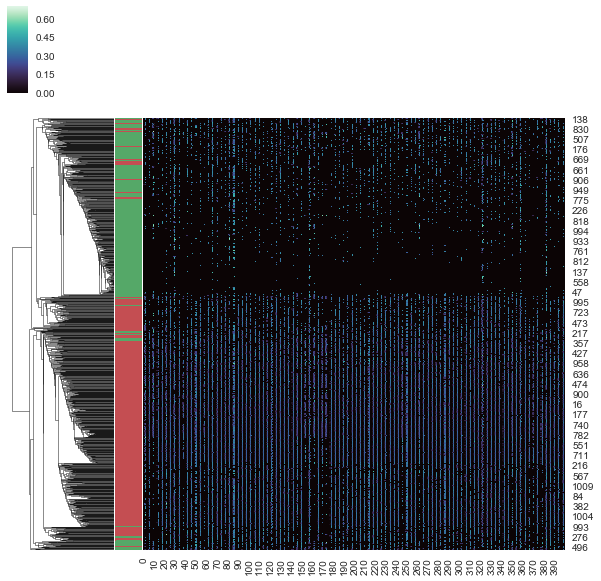

In [195]:

import seaborn as sns; sns.set(color_codes=True)
import pandas as pd

print(TrainCodebook.shape)

foo = pd.Series(svm_clf.predict(TrainCodebook))
#foo = pd.Series(Y_train)#, index=Y_train_names)
data = pd.DataFrame(TrainCodebook)#, index=Y_train_names)
lut = dict(zip(foo.unique(), "rg"))
row_colors = foo.map(lut)
print(lut)

g = sns.clustermap(data, col_cluster=False, metric='cityblock', cmap="mako",
                 row_colors=row_colors,figsize=(10, 10))

#print(row_colors)
del foo, data, lut, row_colors 

### Compute Summary Evaluation Metrics for Test Set

In [196]:
print("\tROC AUC: %0.2f+/-%0.2f"%(roc_auc.mean(),roc_auc.std()))
print("\tRecall: %0.2f+/-%0.2f"%(Recall.mean(),Recall.std()))
print("\tPrecision: %0.2f+/-%0.2f"%(Precision.mean(),Precision.std()))
print("\tF1-Score: %0.2f+/-%0.2f"%(F_Score.mean(),F_Score.std()))


print(fpr[None,:].T.shape,tpr.T.shape)

my_df = pd.DataFrame(np.concatenate((fpr[None,:].T, tpr.T),axis=1)) 
my_df.to_csv('ROC.csv', index=False, header=False) 
del my_df

my_df = pd.DataFrame(np.concatenate((roc_auc,Recall,Precision,F_Score), axis=1)) 

my_df.to_csv('Stats.csv', index=False, header=False) 

#stats.tofile('ROC_AUC.csv',sep=',',format='%10.5f')
#Recall.tofile('Recall.csv',sep=',',format='%10.5f')
#Precision.tofile('Precision.csv',sep=',',format='%10.5f')


	ROC AUC: 0.90+/-0.02
	Recall: 0.90+/-0.02
	Precision: 0.81+/-0.02
	F1-Score: 0.85+/-0.01
((100, 1), (100, 5))


(array([ 0.05606061,  0.12424242,  0.13333333,  0.21666667,  0.25      ,
        0.3530303 ,  0.46363636,  0.48787879,  0.51515152,  0.63333333,
        0.66060606,  0.68484848,  0.71363636,  0.75606061,  0.78181818,
        0.79848485,  0.81666667,  0.84545455,  0.86060606,  0.87272727,
        0.87424242,  0.89090909,  0.8969697 ,  0.9030303 ,  0.90606061,
        0.91515152,  0.91666667,  0.91969697,  0.92424242,  0.93181818,
        0.94090909,  0.94090909,  0.94393939,  0.94848485,  0.96212121,
        0.96363636,  0.96363636,  0.97272727,  0.97727273,  0.97878788,
        0.98030303,  0.98030303,  0.98030303,  0.98030303,  0.98484848,
        0.98484848,  0.98636364,  0.98636364,  0.98636364,  0.98787879,
        0.98787879,  0.98939394,  0.98939394,  0.98939394,  0.98939394,
        0.98939394,  0.98939394,  0.98939394,  0.98939394,  0.98939394,
        0.98939394,  0.98939394,  0.98939394,  0.98939394,  0.98939394,
        0.99090909,  0.99090909,  0.99090909,  0.99090909,  0.9

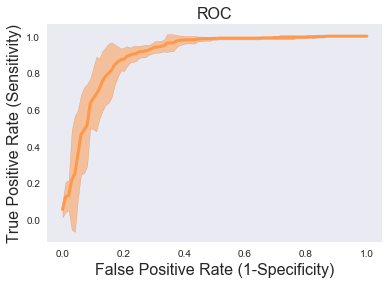

In [198]:
# ROC Curve
mtpr = tpr.mean(axis=0)
CIROC = 1.96*tpr.std(axis=0) # Assuming Normal

plt.figure()
plt.plot(fpr, mtpr, lw=3, label='AUC %0.2f+/-%0.2f'%(roc_auc.mean(),roc_auc.std()), color='#FF9848')
plt.fill_between(fpr, mtpr-CIROC, mtpr+CIROC, alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xlabel('False Positive Rate (1-Specificity)',fontsize=16)
plt.ylabel('True Positive Rate (Sensitivity)',fontsize=16)
plt.title('ROC',fontsize=16)
plt.grid(False)
plt.show()

pd.DataFrame(np.concatenate((fpr[:,None],mtpr[:,None]),axis=1)).to_csv('temp_bovw.csv')





(2, 2)
[[ 0.76585366  0.23414634]
 [ 0.09848485  0.90151515]]
(array([ 0.76585366,  0.23414634]), array([ 0.09848485,  0.90151515]))


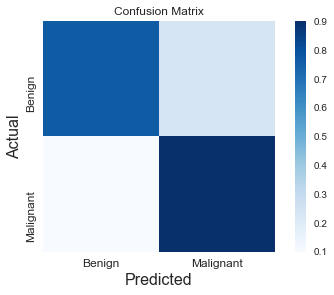

In [199]:
mcm = cm.mean(axis=0).squeeze()

print(mcm.shape)
CIcm = 1.96*cm.std(axis=1)

# Confusion Matrix
target_names = ['Benign','Malignant']
cm_normalized = mcm.astype('float') / mcm.sum(axis=1)[:, np.newaxis]
print(cm_normalized)
print(cm_normalized[0],cm_normalized[1])

plt.figure()
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names,fontsize=12)
plt.yticks(tick_marks, target_names, rotation=90,fontsize=12)
plt.tight_layout()
plt.ylabel('Actual',fontsize=16)
plt.xlabel('Predicted',fontsize=16)
plt.gca().xaxis.grid(False)
plt.gca().yaxis.grid(False)
plt.show()
